In [1]:
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 18
rcParams['axes.linewidth'] = 2
rcParams['grid.linewidth'] = 2
rcParams['grid.color'] = 'gainsboro'
rcParams['font.weight'] = 'normal'
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 21
rcParams['legend.edgecolor'] = 'none'

In [3]:
holdout_path = '../test_results/holdout_validation/'
external_path = '../test_results/external_validation/'

# Holdout validation

In [4]:
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import pickle
import statsmodels.api as sm

def drawBoxplot(results_name, test, var, c):
    preds = []
    for rsi in range(1,6):
        pred = pickle.load(open('{}_rs{}_testresults.pkl'.format(results_name,rsi), 'rb'))
        order = np.argsort(pred['avg'][0].values)
        preds.append(pred['avg'][1][order])
        reals = pred['avg'][0].values[order]
    avg_preds = np.mean(preds, 0)
    
    r, p = spearmanr(reals, avg_preds)
    #r, p = pearsonr(reals, avg_preds)

    #### DENSITY PLOT
    plt.figure(figsize=(5,5))
    kde_df = pd.DataFrame.from_dict({'reals':reals,'avg_preds':avg_preds})
    kp = sns.kdeplot(data=kde_df, x='reals', y='avg_preds', fill=False, color=c[1])
    plt.plot(reals, avg_preds, 'ok', color=c[2])
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.subplots_adjust(left=0.3, right=0.95, bottom=0.125, top=0.98)
    #plt.xlabel('log(V2/V1) real')
    #plt.ylabel('log(V2/V1) predicted \n Hold-out validation')
    #plt.text(0.8, 0.15, '$r$={:.2f}'.format(r), transform = plt.gca().transAxes, size=30)    
    #plt.text(0.8, 0.07, '$p$={:.2f}'.format(p), transform = plt.gca().transAxes, size=30)
    plt.show()


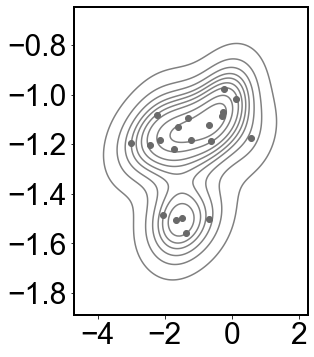

In [5]:
test_results = holdout_path+'cum_treatment_relative_change_basic'
treat_colors = ['lightgrey', 'grey', 'dimgrey']
drawBoxplot(test_results, 'holdout', 'treatment', treat_colors)

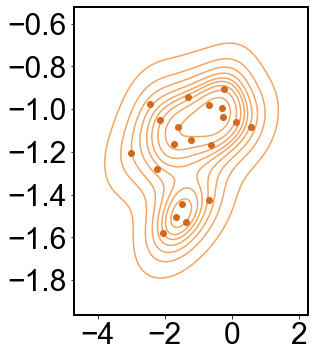

In [6]:
test_results = holdout_path+'cum_ca125_relative_change_basic'
ca125_colors = ['peachpuff','sandybrown','chocolate']
drawBoxplot(test_results, 'holdout', 'ca125', ca125_colors)

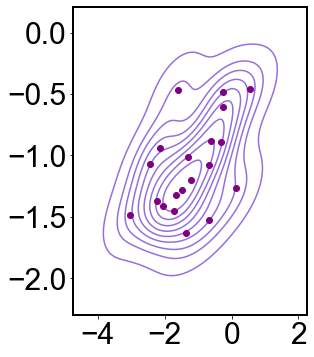

In [7]:
test_results = holdout_path+'cum_ratio_radiomics_relative_change_basic'
rad_colors = ['thistle','mediumpurple','purple']
drawBoxplot(test_results, 'holdout', 'ratio_radiomics', rad_colors)

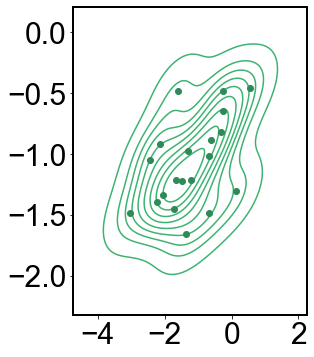

In [8]:
test_results = holdout_path+'cum_ctdna_relative_change_basic'
ctdna_colors = ['honeydew','mediumseagreen','seagreen']
drawBoxplot(test_results, 'holdout', 'cum_ctdna', ctdna_colors)

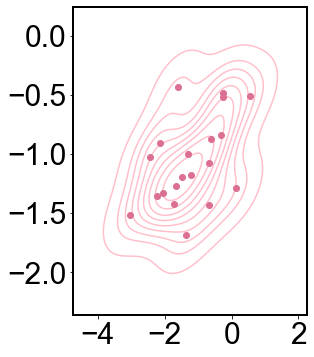

In [9]:
test_results = holdout_path+'barts_features_relative_change_basic'
colors = ['lavenderblush','pink','palevioletred']
drawBoxplot(test_results, 'holdout', 'barts_features', colors)

Let's try and get the bootstraps: 

In [10]:
from sklearn.metrics import roc_auc_score
import numpy as np

cum_treatment $r_S$=0.49, $p$=0.03 & $r_P$=0.30, $p$=0.20
cum_ca125 $r_S$=0.37, $p$=0.11 & $r_P$=0.32, $p$=0.17
cum_ratio_radiomics $r_S$=0.50, $p$=0.02 & $r_P$=0.50, $p$=0.02
cum_ctdna $r_S$=0.50, $p$=0.02 & $r_P$=0.49, $p$=0.03
[0.         0.01467344 0.15399528 0.13965599]


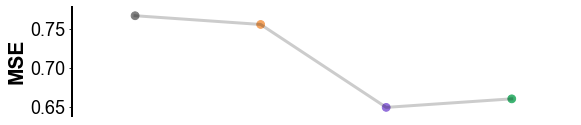

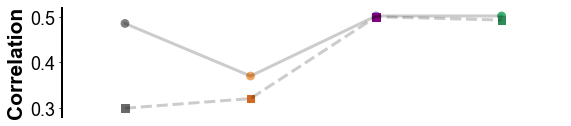

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

test_models = ['cum_treatment', 'cum_ca125', 'cum_ratio_radiomics', 'cum_ctdna']
test_names = ['+Tx', '+CA125', '+Rad', '+ctDNA']
colors = [treat_colors[1], ca125_colors[1], rad_colors[1], ctdna_colors[1]]
colors2 = [treat_colors[2], ca125_colors[2], rad_colors[2], ctdna_colors[2]]

holdout_mses = []
holdout_spearman = []
holdout_pearson = []

for test_model in test_models:
    preds = []
    results_name = holdout_path+test_model+ '_relative_change_basic'
    for rsi in range(1,6):
        pred = pickle.load(open('{}_rs{}_testresults.pkl'.format(results_name,rsi), 'rb'))
        order = np.argsort(pred['avg'][0].values)
        preds.append(pred['avg'][1][order])
        reals = pred['avg'][0].values[order]
    avg_preds = np.mean(preds, 0)

    mse = mean_squared_error(reals, avg_preds)
    holdout_mses.append(mse)
    
    rs,rs_p = spearmanr(reals, avg_preds)
    holdout_spearman.append(rs)
    
    rp,rp_p = pearsonr(reals, avg_preds)
    holdout_pearson.append(rp)
    
    print(test_model, '$r_S$={:.2f}, $p$={:.2f} & $r_P$={:.2f}, $p$={:.2f}'.format(rs,rs_p, rp, rp_p))


### MSEs
plt.figure(figsize=(9,2))
plt.plot(holdout_mses, '-', linewidth=3, color='k', alpha=0.2)
plt.scatter(x=range(4), y=holdout_mses, c=colors, s=60)
plt.xticks(range(len(test_names)), test_names, rotation=0)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
print(1-holdout_mses/holdout_mses[0])

plt.xlim([-0.5,3.5])
plt.ylabel('MSE')
plt.show()

## Correlation coeffs
plt.figure(figsize=(9,2))
# Spearman
plt.plot(holdout_spearman, '-', linewidth=3, color='k', alpha=0.2)
plt.scatter(x=range(4), y=holdout_spearman, c=colors, s=60)
# Pearson
plt.plot(holdout_pearson, '--', linewidth=3, color='k', alpha=0.2)
plt.scatter(x=range(4), y=holdout_pearson, c=colors2, s=60, marker='s')
# Other stuff
plt.xticks(range(len(test_names)), test_names, rotation=0)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim([-0.5,3.5])
plt.ylabel('Correlation')
plt.show()

# External (Barts) validation

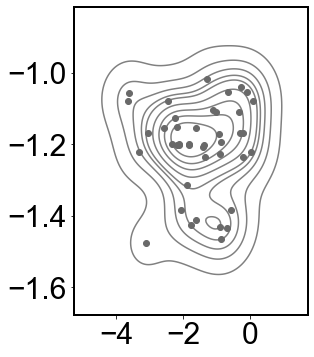

In [12]:
test_results = external_path+'cum_age_stage_relative_change_basic'
colors = ['lightgrey', 'grey', 'dimgrey']
drawBoxplot(test_results, 'barts', 'age_stage', colors)

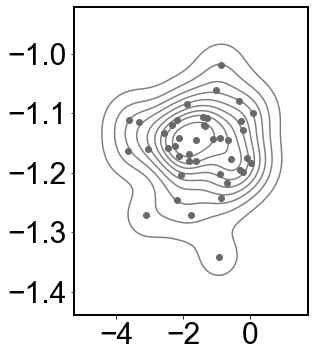

In [13]:
test_results = external_path+'cum_treatment_relative_change_basic'
colors = ['lightgrey', 'grey', 'dimgrey']
drawBoxplot(test_results, 'barts', 'treatment', colors)

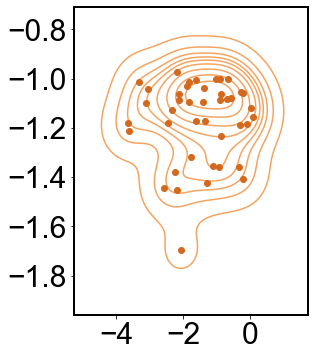

In [14]:
test_results = external_path+'cum_ca125_relative_change_basic'
colors = ['peachpuff','sandybrown','chocolate']
drawBoxplot(test_results, 'barts', 'ca125', colors)

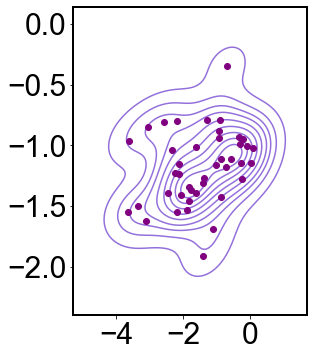

In [15]:
test_results = external_path+'cum_ratio_radiomics_relative_change_basic'
colors = ['thistle','mediumpurple','purple']
drawBoxplot(test_results, 'barts', 'ratio_radiomics', colors)

cum_treatment $r_S$=-0.00, $p$=0.98 & $r_P$=0.03, $p$=0.85
cum_ca125 $r_S$=0.04, $p$=0.80 & $r_P$=0.03, $p$=0.84
cum_ratio_radiomics $r_S$=0.32, $p$=0.04 & $r_P$=0.29, $p$=0.07
[ 0.         -0.00714843  0.08613962         nan]


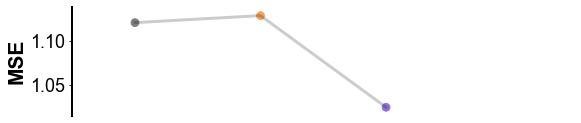

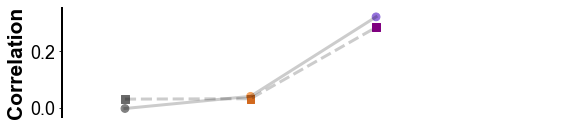

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

test_models = ['cum_treatment', 'cum_ca125', 'cum_ratio_radiomics']
test_names = ['+Tx', '+CA125', '+Rad', '+ctDNA']
colors = [treat_colors[1], ca125_colors[1], rad_colors[1], ctdna_colors[1]]
colors2 = [treat_colors[2], ca125_colors[2], rad_colors[2], ctdna_colors[2]]

barts_mses = []
barts_spearman = []
barts_pearson = []

for test_model in test_models:
    preds = []
    results_name = external_path+test_model+ '_relative_change_basic'
    for rsi in range(1,6):
        pred = pickle.load(open('{}_rs{}_testresults.pkl'.format(results_name,rsi), 'rb'))
        order = np.argsort(pred['avg'][0].values)
        preds.append(pred['avg'][1][order])
        reals = pred['avg'][0].values[order]
    avg_preds = np.mean(preds, 0)

    mse = mean_squared_error(reals, avg_preds)
    barts_mses.append(mse)
    
    rs,rs_p = spearmanr(reals, avg_preds)
    barts_spearman.append(rs)
    
    rp,rp_p = pearsonr(reals, avg_preds)
    barts_pearson.append(rp)
    
    print(test_model, '$r_S$={:.2f}, $p$={:.2f} & $r_P$={:.2f}, $p$={:.2f}'.format(rs,rs_p, rp, rp_p))

barts_mses.append(np.nan)
barts_spearman.append(np.nan)
barts_pearson.append(np.nan)

### MSEs
print(1-barts_mses/barts_mses[0])
plt.figure(figsize=(9,2))
plt.plot(barts_mses, '-', linewidth=3, color='k', alpha=0.2)
plt.scatter(x=range(4), y=barts_mses, c=colors, s=60)
plt.xticks(range(len(test_names)), test_names, rotation=0)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim([-0.5,3.5])
plt.ylabel('MSE')
plt.show()

## Correlation coeffs
plt.figure(figsize=(9,2))
# Spearman
plt.plot(barts_spearman, '-', linewidth=3, color='k', alpha=0.2, label='Spearman')
plt.scatter(x=range(4), y=barts_spearman, c=colors, s=60)
# Pearson
plt.plot(barts_pearson, '--', linewidth=3, color='k', alpha=0.2, label='Pearson')
plt.scatter(x=range(4), y=barts_pearson, c=colors2, s=60, marker='s')
# Other stuff
plt.xticks(range(len(test_names)), test_names, rotation=0)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim([-0.5,3.5])
plt.ylabel('Correlation')
plt.show()

# Correlation of predictions with RECIST

### Holdout dataset

In [17]:
df_holdout = pd.read_csv('../prediction/inputs/testing_df.csv')
df_recist_holdout = pd.read_csv('../data/neov-recist.csv')

In [18]:
# Get RECIST data
df_holdout_merged = pd.merge(left=df_recist_holdout, right=df_holdout[['id','relative_change']], left_on='ID', right_on='id', how='inner')
recist_status = df_holdout_merged['response_volume']
recist_id = df_holdout_merged['ID']

perc_vol_change = np.log(df_holdout['relative_change'])

cum_treatment


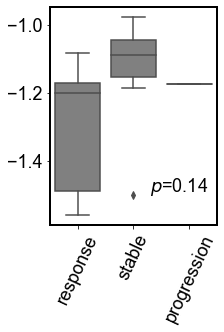

cum_ca125


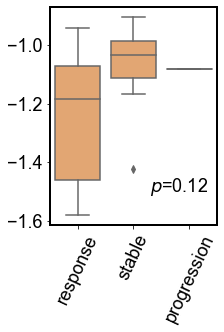

cum_ratio_radiomics


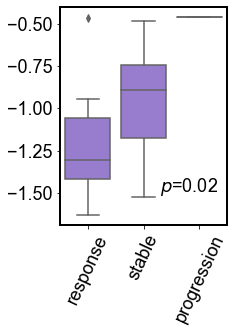

In [19]:
#Holdout
from scipy.stats import mannwhitneyu, pointbiserialr
colors = [treat_colors[1], ca125_colors[1], rad_colors[1], ctdna_colors[1]]

coefs = []
for ix,test_model in enumerate(test_models):
    print(test_model)
    preds = []
    for rsi in range(1,6):
        results_name = holdout_path+test_model+'_relative_change_basic'
        pred = pickle.load(open('{}_rs{}_testresults.pkl'.format(results_name,rsi), 'rb'))
        order = np.argsort(pred['avg'][0].values)
        preds.append(pred['avg'][1][order])
        reals = pred['avg'][0].values[order]
    avg_preds = np.mean(preds, 0)
    
    # Stats
    plot_df = pd.DataFrame({'RECIST':recist_status[order], 'pred_change':avg_preds, 'ID':recist_id[order]})

    m1 = mannwhitneyu(plot_df['pred_change'].values[plot_df['RECIST']=='response'], plot_df['pred_change'].values[plot_df['RECIST']=='stable'])
    m3 = mannwhitneyu(plot_df['pred_change'].values[plot_df['RECIST']=='stable'], plot_df['pred_change'].values[plot_df['RECIST']=='progression'])
    
    plot_df['RECIST_num'] = plot_df['RECIST'].copy()
    plot_df['RECIST_num'].replace('response',1,inplace=True)
    plot_df['RECIST_num'].replace('stable',2,inplace=True)
    plot_df['RECIST_num'].replace('progression',3,inplace=True)  
    pb = pointbiserialr(plot_df['RECIST_num'].values, plot_df['pred_change'].values)
    
    plt.figure(figsize=(3,4))
    sns.boxplot(data=plot_df, x='RECIST', y='pred_change', color=colors[ix])
    plt.text(0.6, 0.15, '$p$={:.2f}'.format(pb.pvalue), transform = plt.gca().transAxes, size=18)    
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=65)
    plt.show()


### Barts dataset

In [20]:
df_barts = pd.read_csv('../prediction/inputs/barts_df.csv')
df_recist_barts = pd.read_csv('../data/barts-recist.csv')

In [21]:
# Original: 1=progressive disease, 2=stable disease, 3=partial response, 4=complete response
# Reversing so it goes from better to worse
# First give names
df_recist_barts['RECIST_call'].replace(2,'stable',inplace=True)
df_recist_barts['RECIST_call'].replace(3,'response',inplace=True)

In [22]:
recist_var_name = 'RECIST_call'
recist_annot = df_recist_barts[['ID','SLD_1','SLD_2',recist_var_name]].copy()
recist_annot['response_volume'] = df_recist_barts.loc[:,recist_var_name].values

df_barts_merged = pd.merge(left=recist_annot, right=df_barts, left_on='ID', right_on='id', how='inner')
recist_status = df_barts_merged['response_volume']
recist_id = df_barts_merged['ID']

perc_vol_change = np.log(df_barts_merged['relative_change'])

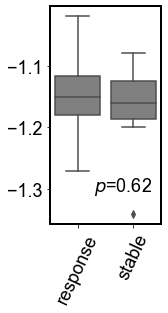

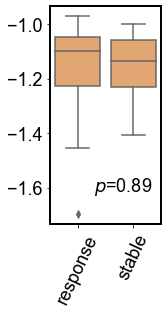

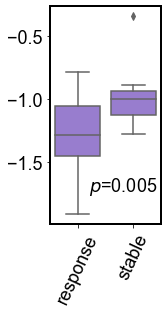

In [23]:
#Barts
colors = [treat_colors[1], ca125_colors[1], rad_colors[1], ctdna_colors[1]]

coefs = []
xs = []
for ix,test_model in enumerate(test_models):
    try:
        preds = []
        for rsi in range(1,6):
            results_name = external_path+test_model+'_relative_change_basic'
            pred = pickle.load(open('{}_rs{}_testresults.pkl'.format(results_name,rsi), 'rb'))
            order = np.argsort(pred['avg'][0].values)
            preds.append(pred['avg'][1][order])
            reals = pred['avg'][0].values[order]
        avg_preds = np.mean(preds, 0)
                
        # Stats
        plot_df = pd.DataFrame({'RECIST':recist_status[order], 'pred_change':avg_preds, 'ID':recist_id[order]})
        m1 = mannwhitneyu(plot_df['pred_change'].values[plot_df['RECIST']=='response'], plot_df['pred_change'].values[plot_df['RECIST']=='stable'])
        
        plot_df['RECIST_num'] = plot_df['RECIST'].copy()
        plot_df['RECIST_num'].replace('response',1,inplace=True)
        plot_df['RECIST_num'].replace('stable',2,inplace=True)
        plot_df['RECIST_num'].replace('progression',3,inplace=True)  
        pb = pointbiserialr(plot_df['RECIST_num'].values, plot_df['pred_change'].values)

        plt.figure(figsize=(2,4))
        sns.boxplot(data=plot_df, x='RECIST', y='pred_change', color=colors[ix])
        plt.ylabel('')
        plt.xlabel('')
        plt.xticks(rotation=65)
        if pb.pvalue<0.01:
            plt.text(0.35, 0.15, '$p$={:.3f}'.format(pb.pvalue), transform = plt.gca().transAxes, size=18)    
        else:
            plt.text(0.4, 0.15, '$p$={:.2f}'.format(pb.pvalue), transform = plt.gca().transAxes, size=18)    
        plt.show()
       
    except:
        print(ix)